In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler

from datetime import datetime
from scipy.io import readsav
import pyreadstat

# Downloading CSV files

In [2]:
filepath_historical_data = '/Users/torstenwrigley/code/MadMax1995bb/powder_alert2.0/raw_data/Hochfuegen_history.csv'
filepath_hist_api = '/Users/torstenwrigley/code/MadMax1995bb/powder_alert2.0/raw_data/historical_api.csv'

In [3]:
filepath_v2 = '/Users/torstenwrigley/code/MadMax1995bb/powder_alert2.0/raw_data/Alternative_data_v2.csv'
filepath_v3 = '/Users/torstenwrigley/code/MadMax1995bb/powder_alert2.0/raw_data/Alternative_data_v3_Davos.csv'

In [4]:
csv_file = filepath_historical_data
df_hist = pd.read_csv(csv_file)
df_hist.head(3)

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,283996800,1979-01-01 00:00:00 +0000 UTC,3600,Hochfügen,47.26759,11.77616,274.75,NaN,273.59,272.69,...,NaN,NaN,NaN,NaN,NaN,95,804,Clouds,overcast clouds,04n
1,284000400,1979-01-01 01:00:00 +0000 UTC,3600,Hochfügen,47.26759,11.77616,274.68,NaN,273.67,272.25,...,NaN,NaN,NaN,NaN,NaN,95,804,Clouds,overcast clouds,04n
2,284004000,1979-01-01 02:00:00 +0000 UTC,3600,Hochfügen,47.26759,11.77616,274.63,NaN,273.77,272.43,...,NaN,NaN,NaN,NaN,NaN,98,804,Clouds,overcast clouds,04n


In [5]:
# csv_file = filepath_v2
# alt2 = pd.read_csv(csv_file)

In [6]:
# csv_file = filepath_v3
# alt3 = pd.read_csv(csv_file, delimiter=';')

In [7]:
csv_file = filepath_hist_api
df_api = pd.read_csv(csv_file)
df_api.head(3)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,sunshine_duration
0,1979-01-01 00:00:00+00:00,-5.499,92.65972,-6.499,-9.440102,0.1,0.1,0.00,0.47,51.0,...,42.120000,-0.749,-0.649,0.301,2.201,0.316,0.315,0.304,0.367,0.0
1,1979-01-01 01:00:00+00:00,-5.349,94.81615,-6.049,-9.425217,0.2,0.1,0.07,0.47,71.0,...,46.079998,-0.749,-0.649,0.301,2.201,0.316,0.315,0.304,0.367,0.0
2,1979-01-01 02:00:00+00:00,-5.449,95.53807,-6.049,-9.401998,0.5,0.1,0.28,0.47,73.0,...,48.600000,-0.749,-0.649,0.301,2.201,0.316,0.315,0.304,0.367,0.0


# Merging two datasets

In [8]:
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402861 entries, 0 to 402860
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   402861 non-null  int64  
 1   dt_iso               402861 non-null  object 
 2   timezone             402861 non-null  int64  
 3   city_name            402861 non-null  object 
 4   lat                  402861 non-null  float64
 5   lon                  402861 non-null  float64
 6   temp                 402861 non-null  float64
 7   visibility           4045 non-null    float64
 8   dew_point            402861 non-null  float64
 9   feels_like           402861 non-null  float64
 10  temp_min             402861 non-null  float64
 11  temp_max             402861 non-null  float64
 12  pressure             402861 non-null  int64  
 13  sea_level            0 non-null       float64
 14  grnd_level           0 non-null       float64
 15  humidity         

In [9]:
#Keeping columns of interest and renaming date column
df_hist_clean = df_hist[['dt_iso','city_name', 'temp_min', 'temp_max']]
df_hist_clean = df_hist_clean.rename(columns={'dt_iso':'date'})
df_hist_clean.tail(2)

,date,city_name,temp_min,temp_max
402859,2024-12-08 22:00:00 +0000 UTC,Hochfügen,267.18,269.03
402860,2024-12-08 23:00:00 +0000 UTC,Hochfügen,267.18,268.97


In [10]:
#Stripping date string and then removing timezone
df_hist_clean['date'] = df_hist_clean['date'].str.replace(' UTC', '').copy()

In [11]:
#Changing date columns to date format
df_hist_clean['date'] = pd.to_datetime(df_hist_clean['date'])
df_api['date'] = pd.to_datetime(df_api['date'])

In [12]:
#Merged df_api with df_hist_clean
df = df_api.merge(df_hist_clean, on = 'date', how='left')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402861 entries, 0 to 402860
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   date                           402861 non-null  datetime64[ns, UTC]
 1   temperature_2m                 402838 non-null  float64            
 2   relative_humidity_2m           402838 non-null  float64            
 3   dew_point_2m                   402838 non-null  float64            
 4   apparent_temperature           402838 non-null  float64            
 5   precipitation                  402838 non-null  float64            
 6   rain                           402838 non-null  float64            
 7   snowfall                       402838 non-null  float64            
 8   snow_depth                     402237 non-null  float64            
 9   weather_code                   402838 non-null  float64            
 10  pressure

# Data cleaning 

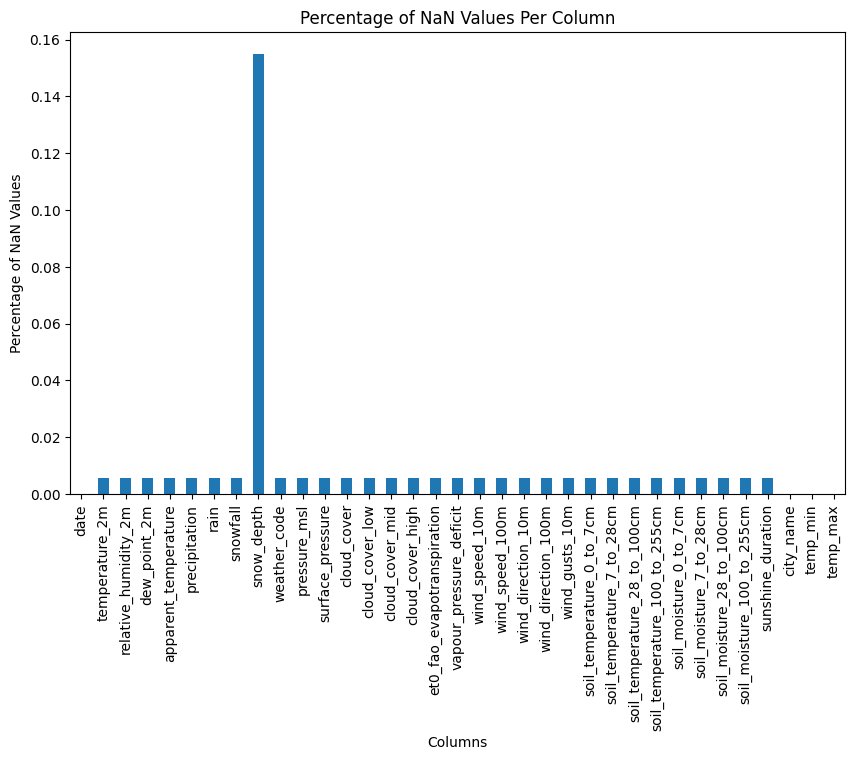

In [14]:
nan_distribution = (df.isna().sum() / len(df)) * 100
nan_distribution.plot(kind='bar', figsize=(10, 6), title='Percentage of NaN Values Per Column')
plt.ylabel('Percentage of NaN Values')
plt.xlabel('Columns')
plt.show();

In [15]:
#Filter out all entries from July 2024 onwards (to deal with missing snow_depth values)

df = df[df['date'] < '2024-07-01']

In [16]:
#Checking and dropping any duplicates duplicates
print(f'Number of rows = {len(df)}') # Check number of rows before removing duplicates

Number of rows = 398997


In [17]:
print(f'Number of duplicates = {df.duplicated().sum()}') # Compute the number of duplicated rows
df = df.drop_duplicates() # Remove duplicates
print(f'Number of rows (after dropping duplicates) = {len(df)}')

Number of duplicates = 165
Number of rows (after dropping duplicates) = 398832


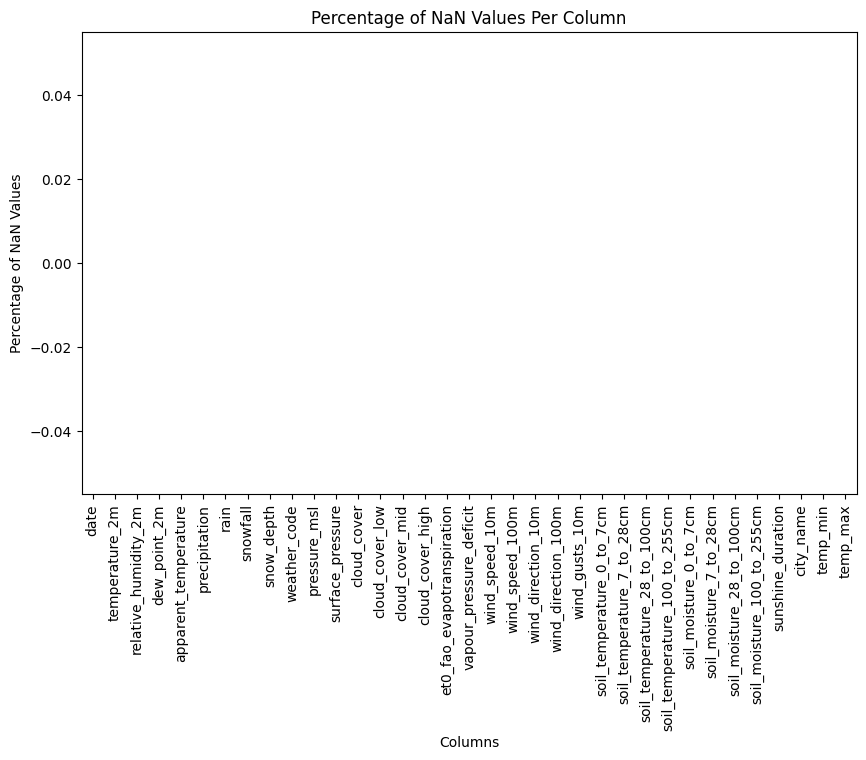

In [18]:
nan_distribution = (df.isna().sum() / len(df)) * 100
nan_distribution.plot(kind='bar', figsize=(10, 6), title='Percentage of NaN Values Per Column')
plt.ylabel('Percentage of NaN Values')
plt.xlabel('Columns')
plt.show();

# Data preprocessing 

In [19]:
#Defining our X value
X = df.drop('snowfall', axis=1)

## Standardasing units of our columns 

In [20]:
#Converting max and min temp from kelvin to celsius
columns_to_convert = ['temp_min', 'temp_max']
for col in columns_to_convert :
    df[col] = df[col] -273.15

## Creating our pipeline

In [21]:
#No changes req for city name
df['weather_code'].value_counts()

weather_code
3.0     99307
0.0     68881
2.0     51107
1.0     44590
71.0    38057
51.0    36131
73.0    31242
53.0    12350
61.0     6257
75.0     4826
55.0     3606
63.0     2439
65.0       39
Name: count, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398832 entries, 0 to 398996
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   date                           398832 non-null  datetime64[ns, UTC]
 1   temperature_2m                 398832 non-null  float64            
 2   relative_humidity_2m           398832 non-null  float64            
 3   dew_point_2m                   398832 non-null  float64            
 4   apparent_temperature           398832 non-null  float64            
 5   precipitation                  398832 non-null  float64            
 6   rain                           398832 non-null  float64            
 7   snowfall                       398832 non-null  float64            
 8   snow_depth                     398832 non-null  float64            
 9   weather_code                   398832 non-null  float64            
 10  pressure_msl 

In [23]:
#No changes req for city name
df['city_name'].value_counts()

city_name
Hochfügen    398832
Name: count, dtype: int64

In [24]:
#Assigning our cat and num variables
cat_columns = ['city_name','weather_code']
num_columns = X.drop(columns=cat_columns + ['date']).select_dtypes(include=['float64']).columns.tolist()

# num_columns.remove('city_name')

# Function to apply LabelEncoder
def label_encode_columns(cat_data):
    for col in cat_columns:
        cat_data[col] = LabelEncoder().fit_transform(cat_data[col])
    return cat_data

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Apply FunctionTransformer to label encode categorical columns
        ('label_encoder', FunctionTransformer(label_encode_columns, validate=False), cat_columns),

        # Apply StandardScaler to numerical columns
        ('standard_scaler', StandardScaler(), num_columns)
    ],
    remainder='passthrough'  # Keeps other columns as is
)

# Create the pipeline
preprocess_pipe = make_pipeline(preprocessor)
preprocess_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label_encoder',
                                                  FunctionTransformer(func=<function label_encode_columns at 0x14a87b400>),
                                                  ['city_name',
                                                   'weather_code']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temperature_2m',
                                                   'relative_humidity_2m',
                                                   'dew_point_2m',
                                                   'apparent_temperature',
                                                   'precipitation', 'rain',
                                                   's...
                                                   'wind_speed_10m',
                                                   'wind_speed_100m',
                                                   'wind_direction_10m',
                                                   'wind_direction_100m',
                                                   'wind_gusts_10m',
                                                   'soil_temperature_0_to_7cm',
                                                   'soil_temperature_7_to_28cm',
                                                   'soil_temperature_28_to_100cm',
                                                   'soil_temperature_100_to_255cm',
                                                   'soil_moisture_0_to_7cm',
                                                   'soil_moisture_7_to_28cm',
                                                   'soil_moisture_28_to_100cm',
                                                   'soil_moisture_100_to_255cm',
                                                   'sunshine_duration',
                                                   'temp_min', ...])]))])

In [25]:
X.describe()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snow_depth,weather_code,pressure_msl,surface_pressure,...,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,sunshine_duration,temp_min,temp_max
count,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,...,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000,398832.000000
mean,3.179015,80.001360,-0.323953,0.720137,0.188062,0.115047,0.426354,22.623104,1017.881851,851.509110,...,4.494577,4.482122,4.487792,0.352614,0.353550,0.345726,0.377814,1223.745346,275.604514,279.227438
std,8.729255,16.470762,8.121207,9.995642,0.476856,0.408049,0.502659,29.843067,7.963953,7.690928,...,4.996257,4.092159,3.128817,0.037985,0.036603,0.038377,0.019141,1636.876104,8.562768,8.500378
min,-35.349000,7.393359,-38.449000,-40.525920,0.000000,0.000000,0.000000,0.000000,969.300000,808.290040,...,-1.549000,-0.499000,0.251000,0.223000,0.250000,0.233000,0.338000,0.000000,239.760000,244.200000
25%,-2.949000,69.877265,-5.899000,-6.467665,0.000000,0.000000,0.000000,1.000000,1013.200000,846.904075,...,0.051000,0.601000,1.501000,0.323000,0.326000,0.315000,0.363000,0.000000,269.110000,272.860000
50%,3.149000,84.300665,0.051000,0.447788,0.000000,0.000000,0.140000,3.000000,1018.300000,852.705350,...,2.201000,3.051000,3.951000,0.355000,0.356000,0.346000,0.378000,0.000000,275.540000,279.190000
75%,9.551001,93.080015,6.351000,8.197078,0.200000,0.000000,0.840000,51.000000,1022.900000,857.117860,...,9.051001,8.401000,7.451000,0.383000,0.383000,0.376000,0.390000,3600.000000,282.080000,285.400000
max,30.099000,100.000000,19.051000,29.438427,13.400000,13.400000,2.130000,75.000000,1047.800000,871.626800,...,18.451000,14.401000,11.151000,0.446000,0.439000,0.444000,0.436000,3600.000000,302.730000,306.310000


In [26]:
X_transformed = preprocess_pipe.fit_transform(X)

In [32]:
X_transformed = pd.DataFrame(X_transformed)
X_transformed.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
398812,0,3,1.279605,0.082923,1.418874,1.367342,-0.39438,-0.281944,-0.848198,-0.939466,...,1.616967,0.594861,-0.990234,0.367449,0.788849,1.890503,-0.747611,1.33082,1.175545,2024-06-30 04:00:00+00:00
398813,0,3,1.434257,-0.206473,1.468128,1.516472,-0.39438,-0.281944,-0.848198,-0.901796,...,1.616967,0.610841,-0.963908,0.340129,0.788849,1.890503,-0.158751,1.350673,1.241424,2024-06-30 05:00:00+00:00
398814,0,2,1.61755,-0.341176,1.603576,1.736193,-0.39438,-0.281944,-0.848198,-0.839013,...,1.616967,0.610841,-0.963908,0.340129,0.788849,1.890503,1.451703,1.52585,1.160251,2024-06-30 06:00:00+00:00
398815,0,4,1.703468,-0.549659,1.603576,1.811197,0.234741,0.453263,-0.848198,-0.864126,...,1.629186,0.610841,-0.911255,0.312809,0.788849,1.890503,1.451703,1.495486,1.306127,2024-06-30 07:00:00+00:00
398816,0,4,1.783658,-0.666551,1.634359,1.867329,0.025034,0.208194,-0.848198,-0.889239,...,1.629186,0.610841,-0.884929,0.285489,0.788849,1.890503,1.451703,1.5749,1.437886,2024-06-30 08:00:00+00:00
398817,0,5,1.800841,-0.539969,1.70824,1.876781,0.654155,0.943401,-0.848198,-0.901796,...,1.629186,0.610841,-0.80595,0.285489,0.762792,1.890503,1.451703,1.5749,1.61082,2024-06-30 09:00:00+00:00
398818,0,9,1.692012,-0.230268,1.72671,1.873794,17.430728,20.548911,-0.848198,-0.8139,...,1.629186,0.610841,1.405458,0.285489,0.762792,1.890503,1.451703,1.535193,1.54494,2024-06-30 10:00:00+00:00
398819,0,7,1.760746,-0.133788,1.837531,1.946371,3.380349,4.129296,-0.848198,-0.864126,...,1.641404,0.610841,1.589742,0.312809,0.762792,1.890503,1.451703,1.5749,1.595527,2024-06-30 11:00:00+00:00
398820,0,9,1.611822,-0.191612,1.658986,1.682524,22.4637,26.430564,-0.848198,-0.77623,...,1.641404,0.610841,1.984637,0.968494,0.762792,1.890503,1.451703,1.5749,1.372007,2024-06-30 12:00:00+00:00
398821,0,2,1.903943,-1.562044,1.308053,1.911821,-0.39438,-0.281944,-0.848198,-0.914352,...,1.641404,0.610841,1.774027,0.586011,0.736734,1.890503,1.451703,1.5749,1.288481,2024-06-30 13:00:00+00:00


In [28]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398832 entries, 0 to 398831
Data columns (total 34 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   0       398832 non-null  object             
 1   1       398832 non-null  object             
 2   2       398832 non-null  object             
 3   3       398832 non-null  object             
 4   4       398832 non-null  object             
 5   5       398832 non-null  object             
 6   6       398832 non-null  object             
 7   7       398832 non-null  object             
 8   8       398832 non-null  object             
 9   9       398832 non-null  object             
 10  10      398832 non-null  object             
 11  11      398832 non-null  object             
 12  12      398832 non-null  object             
 13  13      398832 non-null  object             
 14  14      398832 non-null  object             
 15  15      398832 non-null  object   

In [29]:
len(cat_columns)

2

In [30]:
len(num_columns)

31